In [110]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

import string

import gensim.downloader
from gensim.test.utils import common_texts
from gensim.models import Word2Vec

from nltk.corpus import stopwords
from nltk import word_tokenize

from IPython.display import display

print(torch.__version__)


1.12.1


In [84]:
DATA_DIR = "data/shakespear.txt"


def load_preprocess_data():
    with open(DATA_DIR, "r") as f:
        data = [l.rstrip().lower() for l in f.readlines()]
    
    data = [line.translate(str.maketrans('', '', string.punctuation)) for line in data]
    data = [word_tokenize(line) for line in data]

    return data

def remove_stopwords(data, sw=stopwords.words("english")):
    res = []
    for line in data:
        original = line
        line = [w for w in line if w not in sw]
        if len(line) < 1:
            line = original
        res.append(line)
    return res

data = load_preprocess_data()
data_clean = remove_stopwords(data)

display(data[:2])
print("=" * 30)
display(data_clean[:2])


[['that',
  'poor',
  'contempt',
  'or',
  'claimd',
  'thou',
  'slept',
  'so',
  'faithful'],
 ['i',
  'may',
  'contrive',
  'our',
  'father',
  'and',
  'in',
  'their',
  'defeated',
  'queen']]

[['poor', 'contempt', 'claimd', 'thou', 'slept', 'faithful'],
 ['may', 'contrive', 'father', 'defeated', 'queen']]

### Models from scratch

No softmax due to [nn.CrossEntropy](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)

In [123]:
def get_output_shape(model, image_dim):
    return model(torch.randint(0, 500, size=image_dim)).data.shape


In [133]:
class CBOW(torch.nn.Module):
    def __init__(self, vocab_size: int, embed_size: int = 300):
        super().__init__()
        self.embedding = torch.nn.Embedding(vocab_size, embed_size, max_norm=1)
        self.out = torch.nn.Linear(embed_size, vocab_size)

    def forward(self, idxs):
        X = self.embedding(idxs).mean(1)
        X = self.out(X)
        return F.softmax(X, dim=1)

cbow_model = CBOW(10_000)
get_output_shape(cbow_model, [1, 5])


torch.Size([1, 10000])

In [136]:
class SkipGram(torch.nn.Module):
    def __init__(self, vocab_size: int, embed_size: int = 300):
        super().__init__()
        self.embedding = torch.nn.Embedding(vocab_size, embed_size, max_norm=1)
        self.out = torch.nn.Linear(embed_size, vocab_size)

    def forward(self, idxs):
        X = self.embedding(idxs)
        X = self.out(X)
        return X

skip_gramm_model = SkipGram(10_000)
get_output_shape(skip_gramm_model, [1, 5])


torch.Size([1, 5, 10000])

### Negative Sampling

Instead of modeling $$P(w_o \mid w_c) = softmax(u_{o}^\top v_{c}) = \frac{\text{exp}(\mathbf{u}_o^\top \mathbf{v}_c)}{ \sum_{i \in \mathcal{V}} \text{exp}(\mathbf{u}_i^\top \mathbf{v}_c)},$$

Negative sampling models $$P(A=1\mid w_c, w_o) = \sigma(\mathbf{u}_o^\top \mathbf{v}_c)$$, and let $T$ be an event that the word $w_o$ from the dictionary $V$ comes from the context window

We also create set $N$ of negative examples that contains words $w_k$ **not from the context window** - let this be an event $N_k$

So in conclusion during the backpropogation step we only update weights for events $A$ and $N_k$ (instead of the whole OHE vector), thus speeding up the training significantly

The [original paper](https://arxiv.org/pdf/1310.4546.pdf)

### Embedding dimentionality

In [85]:
model_4 = Word2Vec(sentences=data_clean, vector_size=4, window=3, min_count=1, workers=4, sg=1)
model_20 = Word2Vec(sentences=data, vector_size=20, window=3, min_count=1, workers=4, sg=1)
model_100 = Word2Vec(sentences=data, vector_size=100, window=3, min_count=1, workers=4, sg=1)


In [146]:
model_4.wv.key_to_index["man"]


19

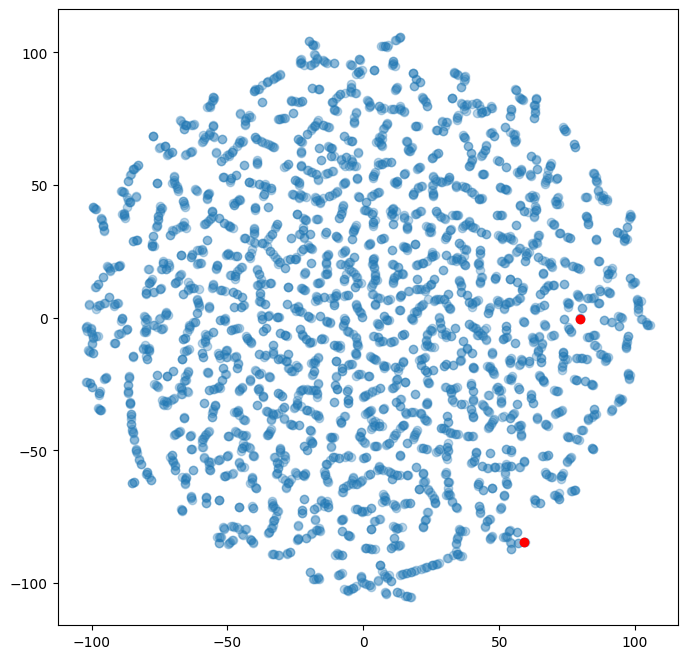

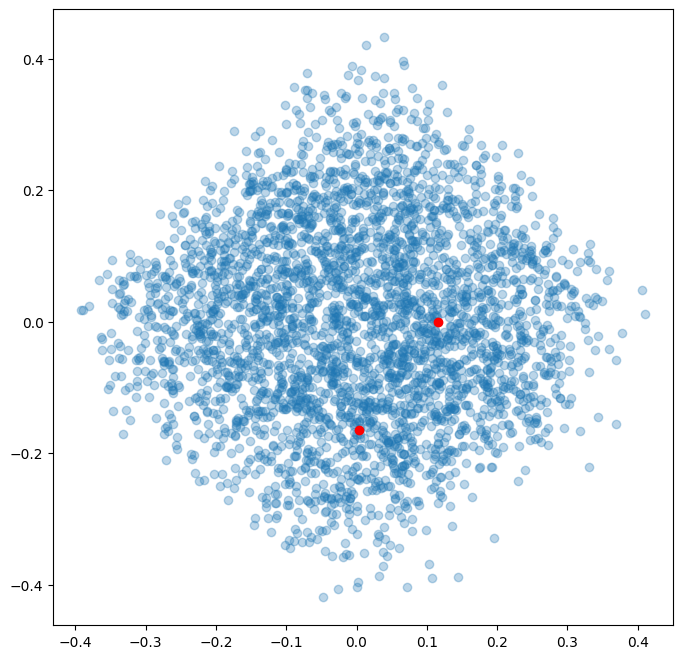

In [149]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

def plot_tsne(wv):
    X = wv.vectors
    man_idx, king_idx = model_4.wv.key_to_index["man"], model_4.wv.key_to_index["king"]
    X_tr = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=3).fit_transform(X)
    plt.figure(figsize=(8, 8))
    plt.scatter(X_tr[:, 0], X_tr[:, 1], alpha=0.3)
    plt.scatter(X_tr[man_idx, 0], X_tr[man_idx, 1], color="red")
    plt.scatter(X_tr[king_idx, 0], X_tr[king_idx, 1], color="red")
    plt.show()

def plot_pca(wv):
    X = wv.vectors
    man_idx, king_idx = model_4.wv.key_to_index["man"], model_4.wv.key_to_index["king"]
    pca = PCA(2)
    X_tr = pca.fit_transform(X)
    plt.figure(figsize=(8, 8))
    plt.scatter(X_tr[:, 0], X_tr[:, 1], alpha=0.3)
    plt.scatter(X_tr[man_idx, 0], X_tr[man_idx, 1], color="red")
    plt.scatter(X_tr[king_idx, 0], X_tr[king_idx, 1], color="red")
    plt.show()
    


plot_tsne(model_4.wv)
plot_pca(model_4.wv)


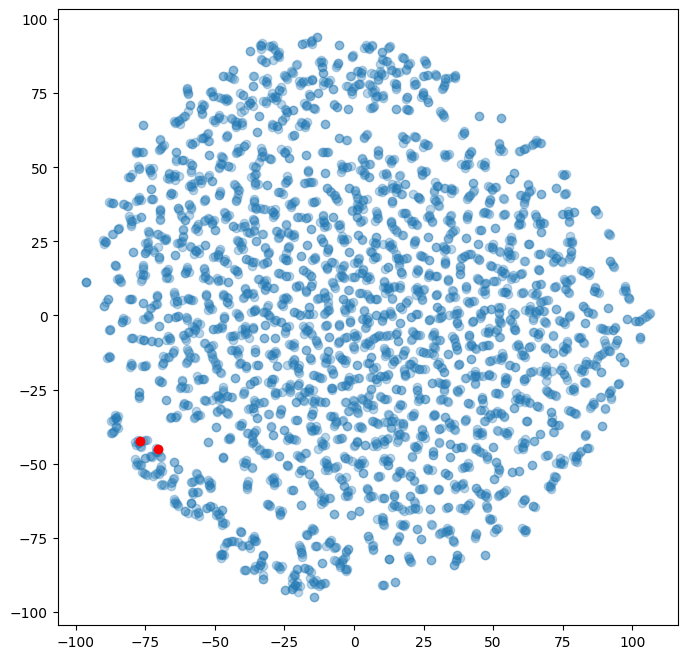

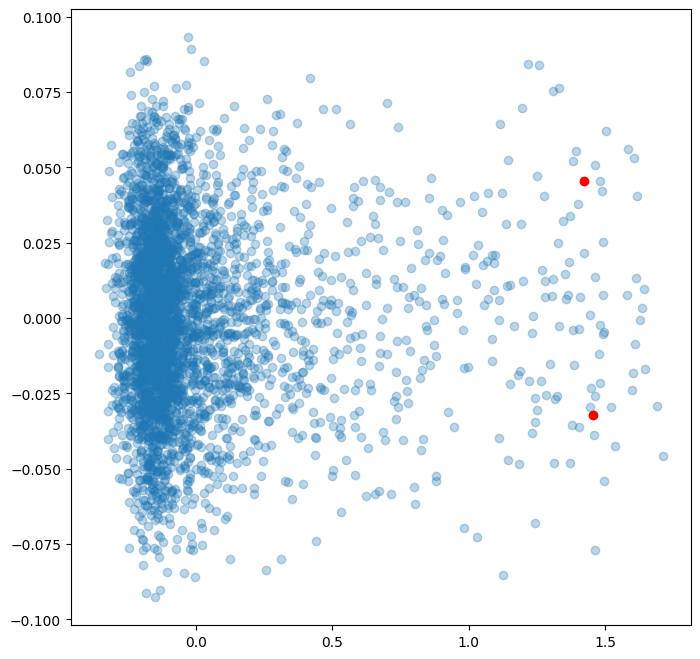

In [154]:
plot_tsne(model_20.wv)
plot_pca(model_20.wv)


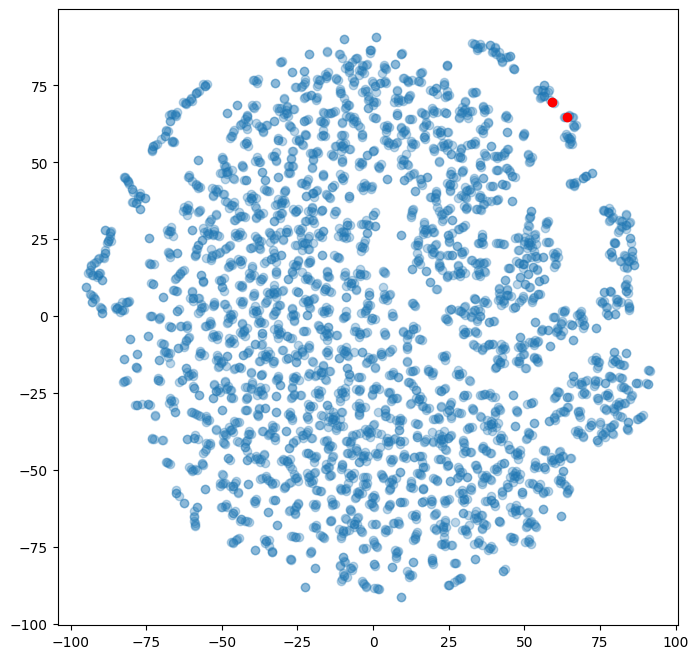

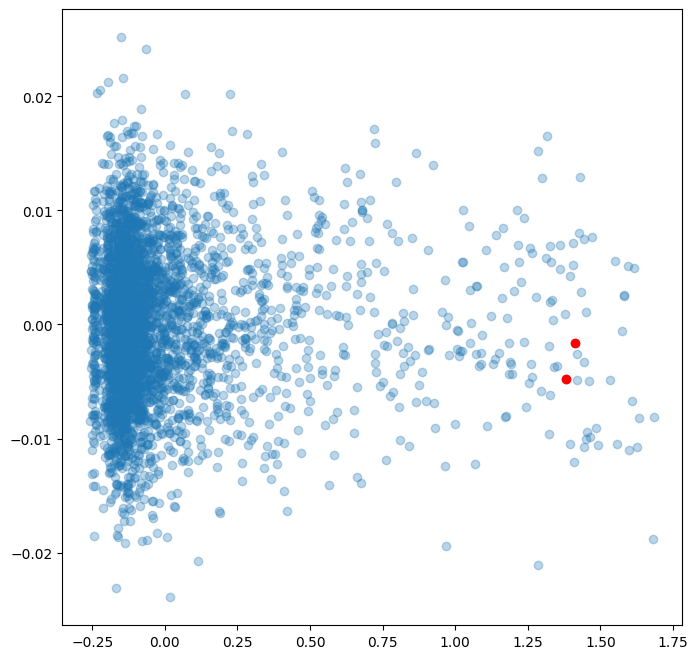

In [156]:
plot_tsne(model_100.wv)
plot_pca(model_100.wv)
